In [66]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
import glob
from PIL import Image

basewidth = 32
wpercent= basewidth/600.0
hsize = int((600.0*float(wpercent)))


all_images = []

for trialname in glob.glob('../Relative_Motion/*'):
    trial_images = []
    for filename in glob.glob(trialname + '/*.jpg'):
        im = Image.open(filename)
        im = im.resize((basewidth, hsize), Image.ANTIALIAS)
        trial_images.append(np.array(im))
            
    all_images.append(trial_images)
            

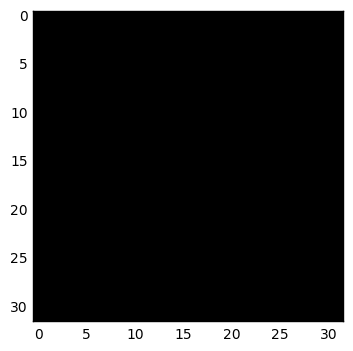

In [173]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
ax = plt.axes()
im = ax.imshow(np.zeros(trial_images[0].shape));

In [206]:
def animate(i, trial_images, im):   
    im.set_data(trial_images[i])
    return


ani = animation.FuncAnimation(fig, animate,  frames = len(trial_images), interval = 20, 
                              blit = False, repeat = False, fargs =(all_images[2],im))

HTML(ani.to_html5_video())

In [177]:
def weights(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def unpool(value, name='unpool'):
    """N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf

    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    """
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat(i, [out, tf.zeros_like(out)])
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

In [235]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
batch_size = 500

n_z = 10 #Dimension of the latent space
# Input
x = tf.placeholder("float32", shape=[None, 1024]) #Batchsize x Number of Pixels
n_hidden_1 = 30
n_hidden_2 = 20

# First hidden layer
W_fc1 = weights([1024, n_hidden_1])
b_fc1 = bias([n_hidden_1])
h_1   = tf.nn.softplus(tf.matmul(x, W_fc1) + b_fc1)

# Second hidden layer
W_fc2 = weights([n_hidden_1, n_hidden_2]) 
b_fc2 = bias([n_hidden_2])
h_2   = tf.nn.softplus(tf.matmul(h_1, W_fc2) + b_fc2)

# Parameters for the Gaussian
z_mu = tf.add(tf.matmul(h_2, weights([n_hidden_2, n_z])), bias([n_z]))
# A little trick:
#  sigma is always > 0.
#  We don't want to enforce that the network produces only positive numbers, therefore we let 
#  the network model the parameter log(\sigma^2) $\in [\infty, \infty]$
z_ls2 = tf.add(tf.matmul(h_2, weights([n_hidden_2, n_z])), bias([n_z])) 

eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32) # Adding a random number
z = tf.add(z_mu, tf.mul(tf.sqrt(tf.exp(z_ls2)), eps))  # The sampled z

n_hidden_1 = 20
n_hidden_2 = 30

W_fc1_g = weights([n_z, n_hidden_1])
b_fc1_g = bias([n_hidden_1])
h_1_g   = tf.nn.softplus(tf.matmul(z, W_fc1_g) + b_fc1_g)

W_fc2_g = weights([n_hidden_1, n_hidden_2])
b_fc2_g = bias([n_hidden_2])
h_2_g   = tf.nn.softplus(tf.matmul(h_1_g, W_fc2_g) + b_fc2_g)

x_mu = tf.add(tf.matmul(h_2_g,  weights([n_hidden_2, 1024])), bias([1024]))
x_ls2 = tf.add(tf.matmul(h_2_g,  weights([n_hidden_2, 1024])), bias([1024]))

reconstr_loss = tf.reduce_sum(0.5 * x_ls2 + (tf.square(x-x_mu)/(2.0 * tf.exp(x_ls2))), 1)
latent_loss = -0.5 * tf.reduce_sum(1 + z_ls2 - tf.square(z_mu) - tf.exp(z_ls2), 1)
cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch

cap_grads = True

if cap_grads == True:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

    gvs = optimizer.compute_gradients(cost)
    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]

    train_step = optimizer.apply_gradients(capped_gvs)
else:
    train_step =  tf.train.AdamOptimizer(0.01).minimize(cost)


# Use ADAM optimizer
#optimizer =  tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)
sess.run(tf.initialize_all_variables())

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f12b80a44d0>> ignored


In [236]:
num_iters = 100

gradients = []

for i in range(num_iters):
    for im_arr in all_images:
        
        if len(im_arr) == 500:
            im_arr = np.array(im_arr).astype('float32')

            im_arr = im_arr[:,:,:,0]
            im_arr -= np.mean(im_arr, axis = 0)
            im_arr /= np.std(im_arr, axis = 0)
        
       
            l, grads, _ = sess.run([cost, gvs, train_step], feed_dict = {x:np.array(im_arr.reshape([-1, 1024]))})
           
            print l
            
            gradients.append(grads)
            

633.886
551.336
528.371
524.846
525.357
525.164
523.877
522.16
520.654
519.449
518.226
517.204
516.453
515.913
515.567
515.231
514.885
514.44
514.314
513.924
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


KeyboardInterrupt: 

In [209]:
t_images = sess.run(output, feed_dict = {x:np.array(im_arr)})

ValueError: Cannot feed value of shape (500, 32, 32) for Tensor u'Placeholder:0', which has shape '(?, 1024)'

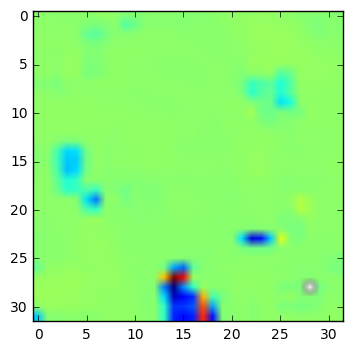

In [278]:
fig = plt.figure()
ax = plt.axes()
im = ax.imshow(im_arr[0]);

In [276]:
im_arr = np.array(all_images[20]).astype('float32')

im_arr = np.max(im_arr[:,:,:,:], axis = 3)
im_arr -= np.mean(im_arr, axis = 0)
im_arr /= np.std(im_arr, axis = 0)

In [280]:
ani = animation.FuncAnimation(fig, animate,  frames = len(trial_images), interval = 5, 
                              blit = False, repeat = False, fargs =(im_arr,im))

HTML(ani.to_html5_video())